In [2]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

In [3]:
#import sys
#sys.path.insert(1, "../src/utils")
#import plots as p

In [4]:
df = pd.read_csv("../src/data/data_oct20.csv").fillna(0)
df = df.rename(columns = {"L": "Load", 
                          "Wind_speed": "Wind Speed", 
                          "Temperature": "Air Temp",
                          "Global_irradiance": "GHI", 
                          "Plane_irradiance": "PAI", 
                          "Module_temp": "Module Temp"})
df.head(2)

,L2_react,L2,Load,L_react,NS4949_export,L2_active_import,PV,Wind Speed,Air Temp,GHI,PAI,Module Temp,Bat_current,Bat_energy,Battery_SOC,Battery_voltage,Battery_charge,Battery_discharge,date,L1
0,-1.672253,8.917166,105.823796,-1.330095,103.75,7.5,0.003709,5.0,1.885714,0.017964,0.018072,0.000171,-0.181818,762.249603,69.649998,751.549988,0.000042,0.000031,2020-10-01 01:00:00,96.906629
1,-1.672253,8.917166,105.823796,-1.330095,103.75,7.5,0.003709,5.0,1.885714,0.017964,0.018072,0.000171,-0.181818,762.249603,69.649998,751.549988,0.000042,0.000031,2020-10-01 01:01:00,96.906629


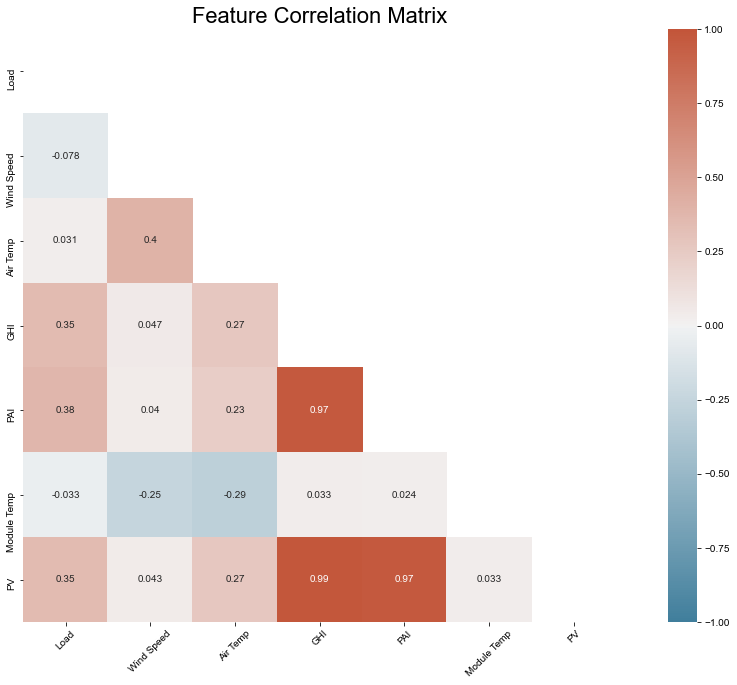

In [5]:
corr = df.filter([ "Load", "Wind Speed", "Air Temp",  "GHI", "PAI",  "Module Temp", "PV"]).corr()
plt.figure(figsize = (15,10))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sn.diverging_palette(230, 20, as_cmap=True)

g = sn.heatmap(corr, mask=mask, vmin = -1, vmax = 1, center = 0, annot=True, square=True, cmap = cmap)#'RdBu')
sn.set(style="white", font_scale= 1.9)
plt.xticks(rotation = 45)

plt.title("Feature Correlation Matrix", fontsize = 22)
plt.tight_layout() 
plt.savefig("../figs/feature_corr.eps", format = "eps")
plt.show()

In [6]:
from statsmodels.graphics.tsaplots import plot_acf

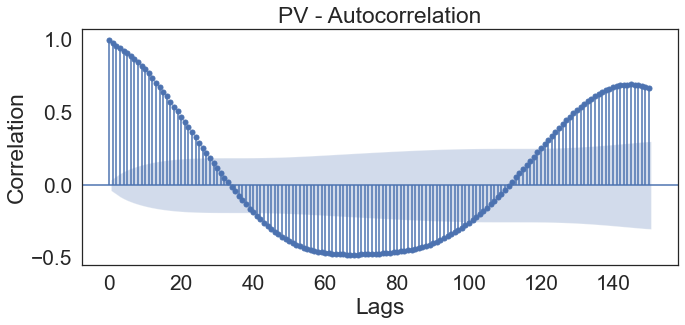

In [7]:
df_new = pd.read_csv("../src/data/8.4_cleaned.csv", parse_dates =["date"]).fillna(0).set_index("date")

#df_auto = df[df["PV"] > 4].reset_index()
_, ax = plt.subplots(figsize =(10,5))
plot_acf(df_new["PV"], lags = 150, ax = ax, alpha = 0.05)
ax.set_title("PV - Autocorrelation")
ax.set_xlabel("Lags")
ax.set_ylabel("Correlation")
plt.tight_layout() 
plt.savefig("../figs/pv_autocorr.png", format = "png")
plt.show()

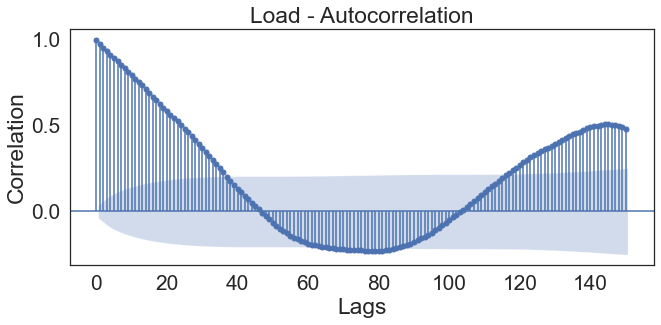

In [8]:
_, ax = plt.subplots(figsize =(10,5))
plot_acf(df_new["L"], lags = 150, ax = ax, alpha = 0.05)
ax.set_title("Load - Autocorrelation")
ax.set_xlabel("Lags")
ax.set_ylabel("Correlation")
plt.tight_layout() 
plt.savefig("../figs/load_autocorr.png", format = "png")
plt.show()

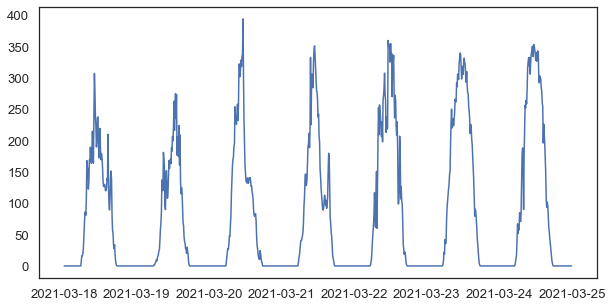

In [9]:

df_red = df_new[df_new.index < datetime(2021, 3, 25)]
plt.figure(figsize = (10, 5))
sn.set(style="white", font_scale= 1.2)
plt.plot(df_red.index,df_red["PV"].values)


In [10]:

def get_predictions(df, timestamp):
    return df[df["collected"] == timestamp]
def plot_prediction(df):
    fig, ax = plt.subplots(figsize = (10,5))
    plt.plot(df.index, df["GHI"])
    plt.fill_between(df.index, df["GHI10"], df["GHI90"], alpha = 0.5, color = "pink")
    time = df.iloc[0]["collected"].strftime("%d %B, %H.%M")
    plt.title("GHI forecast with 90% confidence interval - {}".format( time))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval = 3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H.%M'))
    plt.xlabel("Time of day")
    sn.set(style="white", font_scale= 1.9)
    plt.ylabel("GHI")
    plt.tight_layout() 
    plt.savefig("../figs/solcast_example.png", format="png")

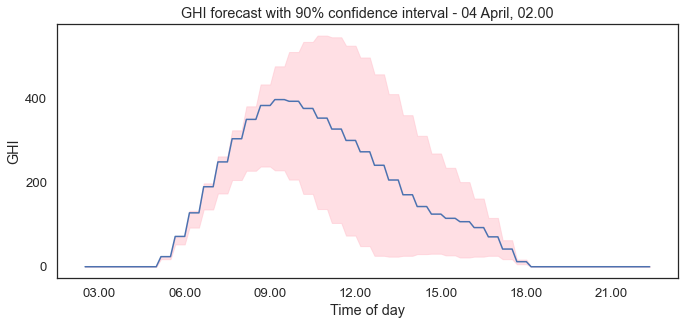

In [11]:
solcast = pd.read_csv("../src/data/solcast_cleaned.csv", parse_dates = ["time", "collected"]).set_index(["time"])


plot_prediction(get_predictions(solcast, datetime(2021, 4, 4, hour = 2)))

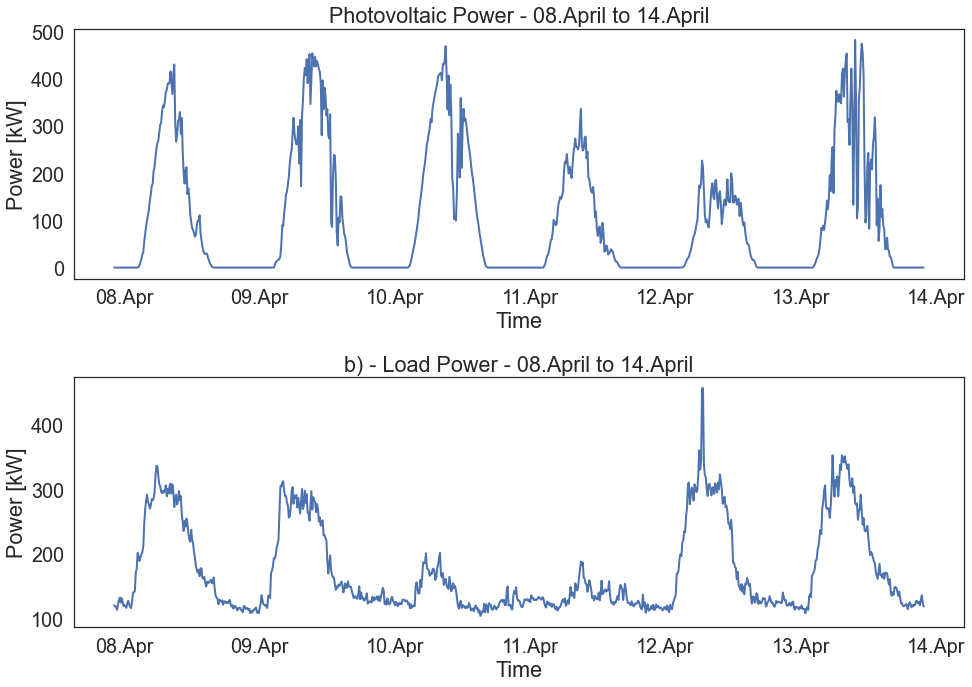

In [16]:
data = pd.read_csv("../src/data/23.4_cleaned.csv", parse_dates = ["date"]).fillna(0).set_index("date")

def plot_days(df, month, day, signal, title = "", n_days = 3, ax = None, interval = 24):
    if not ax: 
        plt.figure(figsize = (10, 5))
        ax = plt.gca()
    start_date = datetime(2021, month, day)
    end_date = start_date + timedelta(days=n_days)

    data_plot = data[(data.index > start_date) & (data.index < end_date)]
    ax.xaxis.set_major_locator(mdates.HourLocator(interval = interval))
    ax.xaxis.set_minor_locator(mdates.HourLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%b'))
    ax.plot(data_plot[signal], lw = 2)
    sn.set(style="white", font_scale= 1.8)

    ax.set_title("{} - {} to {}".format(title, start_date.strftime("%d.%B"),end_date.strftime("%d.%B") ))
    ax.set_ylabel("Power [kW]")
    ax.set_xlabel("Time")

month = 4
day = 8
n_days = 6
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14,10))
plot_days(data, month, day, "PV", title = "Photovoltaic Power", ax = ax1, n_days = n_days)
plot_days(data, month, day, "L", title = "b) - Load Power", ax = ax2, n_days = n_days)
plt.tight_layout()
#plt.savefig("../figs/PV-example.png", format = "png")

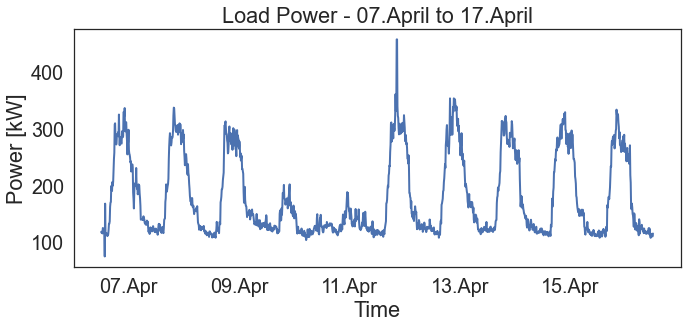

In [24]:
month = 4
day = 7
n_days = 10
plot_days(data, month, day, "L", title = "Load Power", ax = None, n_days = n_days, interval = 48)
plt.tight_layout()
#plt.savefig("../figs/load_example.png", format = "png")

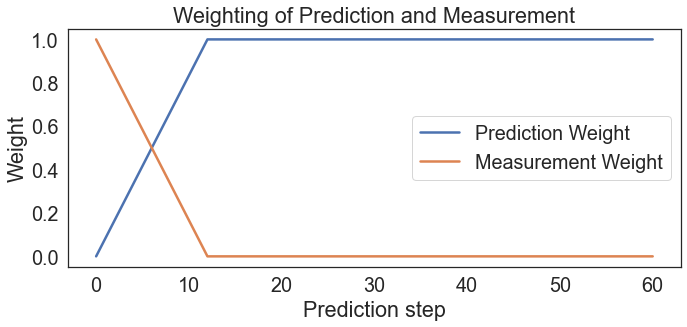

In [47]:
pred = np.ones(60)
pred_weight = np.append(np.linspace(0, 1, 12 + 1), np.ones(len(pred) - 12))
measurement_weight = np.append( np.linspace(1, 0, 12 + 1), np.zeros(len(pred) - 12))

plt.figure(figsize=(10, 5))
sn.set(style="white", font_scale=1.8, rc={"lines.linewidth": 2.5})
plt.plot(pred_weight, label = "Prediction Weight")
plt.plot(measurement_weight, label = "Measurement Weight")
plt.legend()
plt.title("Weighting of Prediction and Measurement")
plt.xlabel("Prediction step")
plt.ylabel("Weight")
plt.tight_layout()
plt.savefig("../figs/linear_mixture.png", format="png")
plt.show()